In [4]:
from typing import TypedDict, Sequence, Annotated
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain.agents import tool, initialize_agent
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

load_dotenv()

True

### add all the function tools that will be used

In [5]:
@tool
def add(a:int, b:int):
    """This is an Addition function that adds two numbers together"""
    return a + b 

@tool
def subtract(a:int, b:int):
    """This is an Substration function that Substract one number from the other"""
    return a - b 

@tool
def multiply(a:int, b:int):
    """This is an Multiplication function that multiplies two numbers"""
    return a * b 



@tool
def divide(a:int, b:int):
    """This is an Division function that divides one numbers from the other"""
    return a / b 

tools = [add,subtract, multiply, divide]

#### create the model, bind the tools to the modela and create AgentState Typed Dictionary (called state) that serves as a memory for the graph

In [6]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20").bind_tools(tools) # For Gemini


class AgentState(TypedDict):
    #this property uses add_meessage to concatenate messages passed to 'messages' instead of overwriting them
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Create the nodes

In [7]:
# node for invoking the llm
def agent_call(state:AgentState)->AgentState:
    system_prompt = SystemMessage(content="You are my AI Assistant. Please answer my query to the best of your ability")

    response = model.invoke([system_prompt] + state['messages'])
    return {"messages":[response]}

# conditional node
def should_continue(state:AgentState):
    messages = state['messages']
    print(messages)
    # check is there is a tool to call on the last message
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'continue'
    else:
        return 'end'



### Graph creation

In [8]:
AGENT="LLM Agent"
TOOL = "Tools"
graph= StateGraph(AgentState)

graph.add_node(AGENT, agent_call)

graph.add_edge(START, AGENT)

tool_node = ToolNode(tools=tools)
graph.add_node(TOOL, tool_node)

graph.add_conditional_edges(
    AGENT,
    should_continue,
    {
        "continue": TOOL,
        "end": END
    }
)

graph.add_edge(TOOL, AGENT)

app = graph.compile()

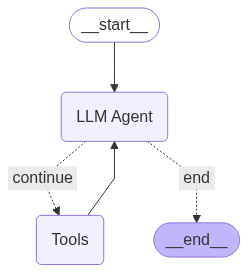

In [9]:
app

#### function to print out the final output in a stream

In [10]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]

        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

#### State the input 

In [11]:
inputs = {"messages":[("user", "Add 3 + 4 and multiply the result by 10")]}

In [12]:
#note path of the code only to test the content of state
def see_state(state:AgentState):
    # state['messages'] = state['messages'].append(inputs)
    print( state['messages'])

see_state(inputs)

[('user', 'Add 3 + 4 and multiply the result by 10')]


In [13]:
stream = app.stream(inputs, stream_mode="values")

### Pass the input in and print out the output

In [17]:
next(stream)

[HumanMessage(content='Add 3 + 4 and multiply the result by 10', additional_kwargs={}, response_metadata={}, id='6c8047f7-52ae-43f5-883c-d57f59946dc8'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--1006a8f7-4d51-43fd-a6ca-36c1ae6c8254-0', tool_calls=[{'name': 'add', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'd0850d07-7b02-4283-9c69-4d15cbc82f26', 'type': 'tool_call'}], usage_metadata={'input_tokens': 240, 'output_tokens': 18, 'total_tokens': 404, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 146}}), ToolMessage(content='7', name='add', id='e2ec93f3-b78a-4873-aa47-fe7a011d9ec7', tool_call_id='d0850d07-7b02-4283-9c69-4d15cbc82f26'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'mult

{'messages': [HumanMessage(content='Add 3 + 4 and multiply the result by 10', additional_kwargs={}, response_metadata={}, id='6c8047f7-52ae-43f5-883c-d57f59946dc8'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--1006a8f7-4d51-43fd-a6ca-36c1ae6c8254-0', tool_calls=[{'name': 'add', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'd0850d07-7b02-4283-9c69-4d15cbc82f26', 'type': 'tool_call'}], usage_metadata={'input_tokens': 240, 'output_tokens': 18, 'total_tokens': 404, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 146}}),
  ToolMessage(content='7', name='add', id='e2ec93f3-b78a-4873-aa47-fe7a011d9ec7', tool_call_id='d0850d07-7b02-4283-9c69-4d15cbc82f26'),
  AIMessage(content='', additional_kwargs={'function_ca

In [29]:
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 3 + 4 and multiply the result by 10
================================== Ai Message ==================================
Tool Calls:
  add (3ef8093e-ba11-4d19-a5aa-2b6bb7759a38)
 Call ID: 3ef8093e-ba11-4d19-a5aa-2b6bb7759a38
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (0935521c-4e6e-453d-aba2-c58428a0d07c)
 Call ID: 0935521c-4e6e-453d-aba2-c58428a0d07c
  Args:
    a: 7.0
    b: 10.0
================================= Tool Message =================================
Name: multiply

70
================================== Ai Message ==================================

The answer is 70.
